In [1]:
import pandas as pd
import pickle
from modules.process_data import *
from modules.utils import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scanpy as sc
from tqdm import tqdm
from modules.dea import *
scaler = StandardScaler()

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-08 15:52:11.457363: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 15:52:12.024349: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Import data

In [2]:
adata1 = anndata.read_h5ad("data/A_count.h5ad")
adata1.obs['Sample_Tag'] = 'LD_5xFAD'
adata2 = anndata.read_h5ad("data/B_count.h5ad")
adata2.obs['Sample_Tag'] = 'LD_NC'
adata = anndata.concat([adata1, adata2], axis=0)
anno_df1 = pd.read_csv("data/A_mapping.csv", skiprows=4)
anno_df2 = pd.read_csv("data/B_mapping.csv", skiprows=4)
anno_df = pd.concat([anno_df1, anno_df2])

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata = anndata.read_h5ad("data/fede_count.h5ad")
anno_df = pd.read_csv("data/fede_mapping.csv", skiprows=4)

# Process data

In [4]:
adata = rm_high_mt(adata, threshold=1)
adata = filter_cells_by_gene_counts(adata)
#adata = rm_low_exp(adata, threshold=0.01)
sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [5]:
#join sample tag to df
sc_df = pd.DataFrame(adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X, index=adata.obs_names, columns=adata.var_names)
sample_tags = pd.DataFrame(adata.obs.Sample_Tag)
sc_df = sc_df.join(sample_tags)

In [6]:
#drop multiplets and undetermined
sc_df = sc_df[~sc_df['Sample_Tag'].isin(['Multiplet', 'Undetermined'])]

In [7]:
#creating annotation df
anno_df = anno_df.set_index('cell_id')[['class_name', "subclass_name", "supertype_name", 'cluster_name']]

In [8]:
#ensure index is type int
sc_df.index = sc_df.index.astype('int64')
anno_df.index = anno_df.index.astype('int64')

In [9]:
#merge expression matrix and annotation
sc_df = sc_df.join(anno_df)

# Select conditions to analyze

In [10]:
#Select tags of interest
tag1 = 'LD_NC'
tag2 = 'LD_5xFAD'

tag1 = 'SampleTag17_flex'
tag2 = 'SampleTag18_flex'

In [11]:
#extract sample tag data
sc_df1 = sc_df[sc_df['Sample_Tag'].isin([tag1])]
sc_df2 = sc_df[sc_df['Sample_Tag'].isin([tag2])]

In [12]:
#extract specific type
sc_df1 = sc_df1[sc_df1['class_name'].isin(['30 Astro-Epen'])]
sc_df2 = sc_df2[sc_df2['class_name'].isin(['30 Astro-Epen'])]

# Type analysis

In [ ]:
X1 = sc_df1.drop(['Sample_Tag', 'class_name', "subclass_name", "supertype_name", 'cluster_name'], axis=1).values
Y1 = sc_df1['class_name'].values
#Y1 = sc_df1['cluster_name'].values

In [ ]:
X2 = sc_df2.drop(['Sample_Tag', 'class_name', "subclass_name", "supertype_name", 'cluster_name'], axis=1).values
Y2 = sc_df2['class_name'].values
#Y2 = sc_df2['cluster_name'].values

In [ ]:
unique_targets = [x for x in Counter(np.concatenate([Y1, Y2])).keys()]
palette = sns.color_palette('Set3', 12) + sns.color_palette('Paired', 12) + sns.color_palette('Set2', 10)
color_mapping = {target: palette[i] for i, target in enumerate(unique_targets)}

In [ ]:
components = 17
pca = PCA(n_components=components)

In [ ]:
X1 = scaler.fit_transform(X1)
X2 = scaler.fit_transform(X2)
X1_pca = pca.fit_transform(X1)
X2_pca = pca.fit_transform(X2)

In [ ]:
n_neighbors_list = [50, 75, 100]
plot_umaps(X1_pca, Y1, n_neighbors_list, color_mapping, min_count=100, classes_to_plot=None)
plot_umaps(X2_pca, Y2, n_neighbors_list, color_mapping, min_count=100, classes_to_plot=None)

In [ ]:
#umap
umap = UMAP(n_neighbors=100, n_components=2, n_jobs=-1)
X1_umap = umap.fit_transform(X1_pca)
X2_umap = umap.fit_transform(X2_pca)

In [ ]:
plot_umap(X1_umap, Y1, color_mapping, min_count=100, classes_to_plot=None)

In [ ]:
plot_umap(X2_umap, Y2, color_mapping, min_count=100, classes_to_plot=None)

# Differential expression analysis

In [59]:
sc_df1 = sc_df1.drop(['Sample_Tag', 'class_name', "subclass_name", "supertype_name", 'cluster_name'], axis=1)
sc_df2 = sc_df2.drop(['Sample_Tag', 'class_name', "subclass_name", "supertype_name", 'cluster_name'], axis=1)

KeyError: "['Sample_Tag', 'class_name', 'subclass_name', 'supertype_name', 'cluster_name'] not found in axis"

In [60]:
#DEA
results_df = differential_expression_analysis(sc_df1, sc_df2)

100%|████████████████████████████████████| 28628/28628 [00:41<00:00, 688.26it/s]


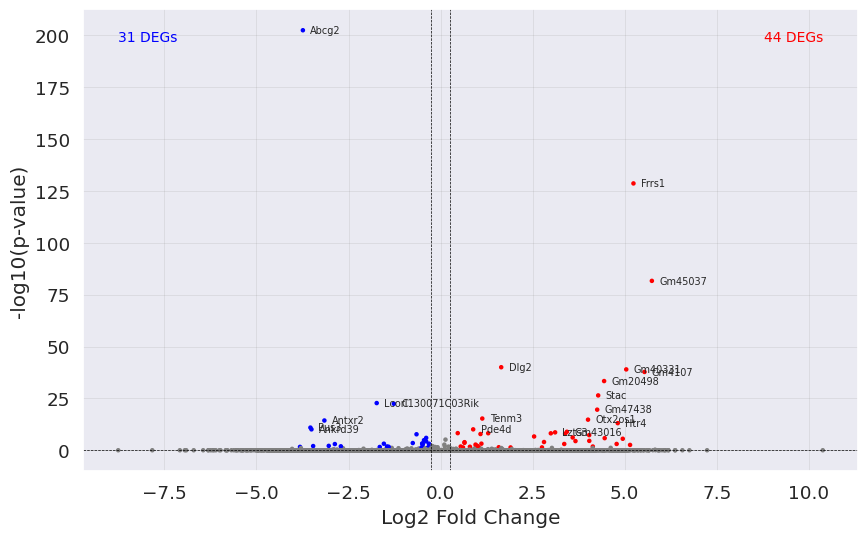

In [101]:
#volcano_plot
significant = get_volcano_plot(results_df, min_fold_change=0.25, max_p_value=0.05)

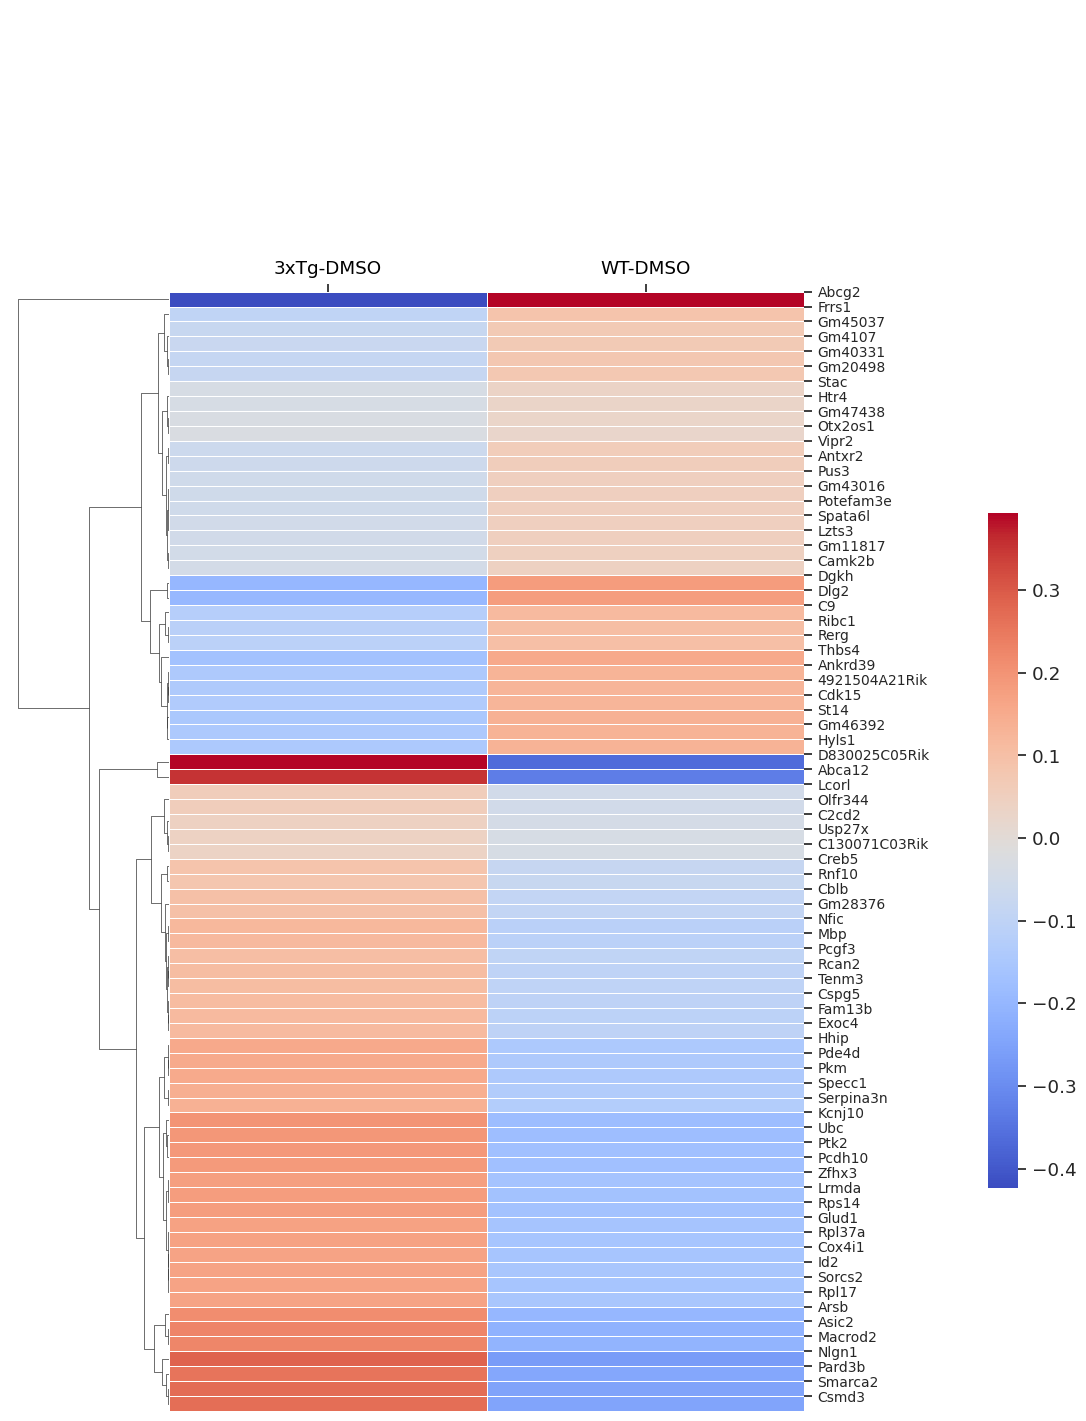

In [116]:
get_heatmap(results_df)